# Illustration of our uncertainty measures on synthetic data

In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
f = lambda x: np.cos(2*np.pi*x)
xaxis = np.linspace(-2.5,1.5,100)
y = f(xaxis)

### Generate data

In [11]:
N_DATA = 200

x_points = []
noise_xpoints_left = np.random.normal(size=int(N_DATA/2))/3
for i in range(int(N_DATA/2)):
    x_points.append(-1 + np.random.normal()/4)
    
noise_xpoints_right = np.random.normal(size=int(N_DATA/2))/3
for i in range(int(N_DATA/2)):
    x_points.append(0.5 + np.random.normal()/6)
    
x_points_ordered = np.sort(x_points)
y_points_ordered = f(x_points_ordered) + np.concatenate([noise_xpoints_left,noise_xpoints_right])

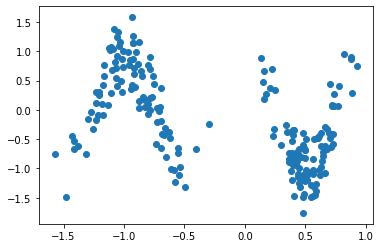

In [12]:
#plt.plot(xaxis,y)
plt.scatter(x_points_ordered,y_points_ordered)

### Now define network and learning parameters, and train

100%|██████████| 10000/10000 [00:34<00:00, 289.51it/s]


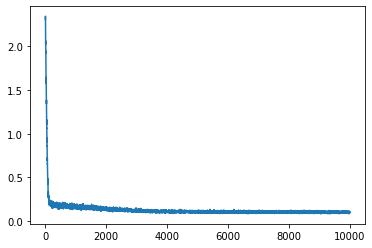

In [17]:
LEARNING_RATE = 2e-4
N_STEPS = 10000
N_QUANTILES = 50
PRIOR = 1e-4
WEIGHT_SCALE = 7
BATCH_SIZE = 64

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

def QRloss(q,y):
    batch_size = q.size(0)
    y = y.repeat((1,N_QUANTILES))
    tau = torch.linspace(0.0, 1.0 - 1./N_QUANTILES, N_QUANTILES) + 0.5 / N_QUANTILES
    tau = tau.unsqueeze(0).repeat(batch_size, 1)
    u = y-q
    return torch.mean((tau - (u < 0).float())*u)

def init_weights(m, gain):
    if (type(m) == nn.Linear) | (type(m) == nn.Conv2d):
        nn.init.orthogonal_(m.weight, gain)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class QRNetwork(nn.Module):
    
    def __init__(self,n_quantiles):
        
        self.n_quantiles = n_quantiles
        super().__init__()
        
        self.predict = nn.Sequential(
            nn.Linear(1, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, self.n_quantiles))
        
        self.predict.apply(lambda x: init_weights(x, WEIGHT_SCALE))
        self.anchor = [p.data.clone() for p in list(self.parameters())]
        
model_1 = QRNetwork(N_QUANTILES)
optimizer_1 = optim.Adam(model_1.parameters(), lr=LEARNING_RATE)

model_2 = QRNetwork(N_QUANTILES)
optimizer_2 = optim.Adam(model_2.parameters(), lr=LEARNING_RATE)

for step in tqdm(range(N_STEPS)):
    
    idx = np.random.randint(len(x_points_ordered), size=BATCH_SIZE)
    x = torch.FloatTensor(x_points_ordered[idx]).unsqueeze(1)
    y = torch.FloatTensor(y_points_ordered[idx]).unsqueeze(1)
    
    q = model_1.predict(x)
    loss = QRloss(q,y)
    
    diff=[]
    for i, p in enumerate(model_1.parameters()):
        diff.append(torch.sum((p - model_1.anchor[i])**2))
    diff = torch.stack(diff).sum()
    
    loss += PRIOR*diff
    
    optimizer_1.zero_grad()
    loss.backward()
    optimizer_1.step()
    
losses = []
for step in tqdm(range(N_STEPS)):
    
    idx = np.random.randint(len(x_points_ordered), size=BATCH_SIZE)
    x = torch.FloatTensor(x_points_ordered[idx]).unsqueeze(1)
    y = torch.FloatTensor(y_points_ordered[idx]).unsqueeze(1)
    
    q = model_2.predict(x)
    loss = QRloss(q,y)
    
    diff=[]
    for i, p in enumerate(model_2.parameters()):
        diff.append(torch.sum((p - model_2.anchor[i])**2))
    diff = torch.stack(diff).sum()
    
    loss += PRIOR*diff
    losses.append(loss.detach())
    
    optimizer_2.zero_grad()
    loss.backward()
    optimizer_2.step()
    
plt.plot(losses)

### Now show predictions, as well as uncertainty intervals

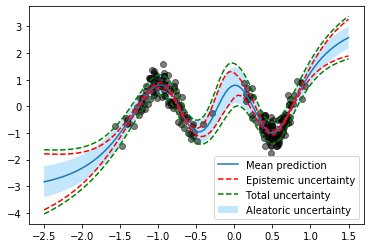

In [21]:
preds_1 = model_1.predict(torch.FloatTensor(xaxis).unsqueeze(1)).detach()
preds_2 = model_2.predict(torch.FloatTensor(xaxis).unsqueeze(1)).detach()

preds_mean =  torch.mean(torch.cat([preds_1,preds_2],dim=1),dim=1)
uncertainty_epistemic = torch.sqrt(torch.mean((preds_1-preds_2)**2,dim=1)/2)
uncertainty_aleatoric = []
for i in range(100):
    stacked_quantiles = torch.stack([preds_1[i],preds_2[i]])
    cov = np.cov(stacked_quantiles)
    uncertainty_aleatoric.append(np.sqrt(cov[0,1]))
uncertainty_aleatoric = torch.FloatTensor(uncertainty_aleatoric)    

total_uncertainty = np.sqrt(uncertainty_epistemic**2 + uncertainty_aleatoric**2)
    
plt.plot(xaxis,preds_mean,label='Mean prediction')

plt.fill_between(xaxis,
         preds_mean - uncertainty_aleatoric,
             preds_mean + uncertainty_aleatoric,
         alpha=0.5, fc='lightskyblue', ec='None',label='Aleatoric uncertainty')

plt.plot(xaxis,preds_mean - uncertainty_epistemic,'--',label="Epistemic uncertainty",color="r")
plt.plot(xaxis,preds_mean + uncertainty_epistemic,'--',color="r")

plt.plot(xaxis,preds_mean - total_uncertainty,'--',label="Total uncertainty",color="g")
plt.plot(xaxis,preds_mean + total_uncertainty,'--',color="g")


plt.legend()
plt.scatter(x_points_ordered,y_points_ordered,alpha=0.5,color='k')